# Forecast Model

In this notebook we'll train a deep learning model that learns if the target price or the stop loss would be hit for a long/short trade in the next hour based on the last two hours of price data.

Model:
* Multilayer Perceptron (MLP) (Feedforward neural network)
* 3 layers: input (29), hidden (14), output (2)
* Binary Classification
* `Input`: SMA(1 to 15 min), ROC(1 to 15 min)
* `Output`: Does a long or short trade hit the profit target (20 points) without hitting a stop loss (10 points) in the next hour? No=0,Yes=1 

In [31]:
model_name="long_short_predict"

with open("model/model_name", "w") as text_file:
    text_file.write(model_name)
model_name

'long_short_predict'

# Step 1) Get Data

In [4]:
import pandas as pd

df = pd.read_csv("../0_data/INTC.csv",infer_datetime_format=True, parse_dates=['dt'], index_col=['dt'])
df.to_csv('local_test/test_dir/input/data/training/data_orig.csv')
print("count=%s" % len(df))
df.head()

count=1825


,open,low,high,close,vol
dt,,,,,
2012-08-13,26.76,26.83,26.41,26.69,23623918.0
2012-08-14,26.80,26.81,26.38,26.48,27477260.0
2012-08-15,26.23,26.47,26.19,26.27,26081909.0
2012-08-16,26.44,26.65,26.34,26.59,25702363.0
2012-08-17,26.57,26.63,26.21,26.33,30379903.0


<IPython.core.display.Javascript object>


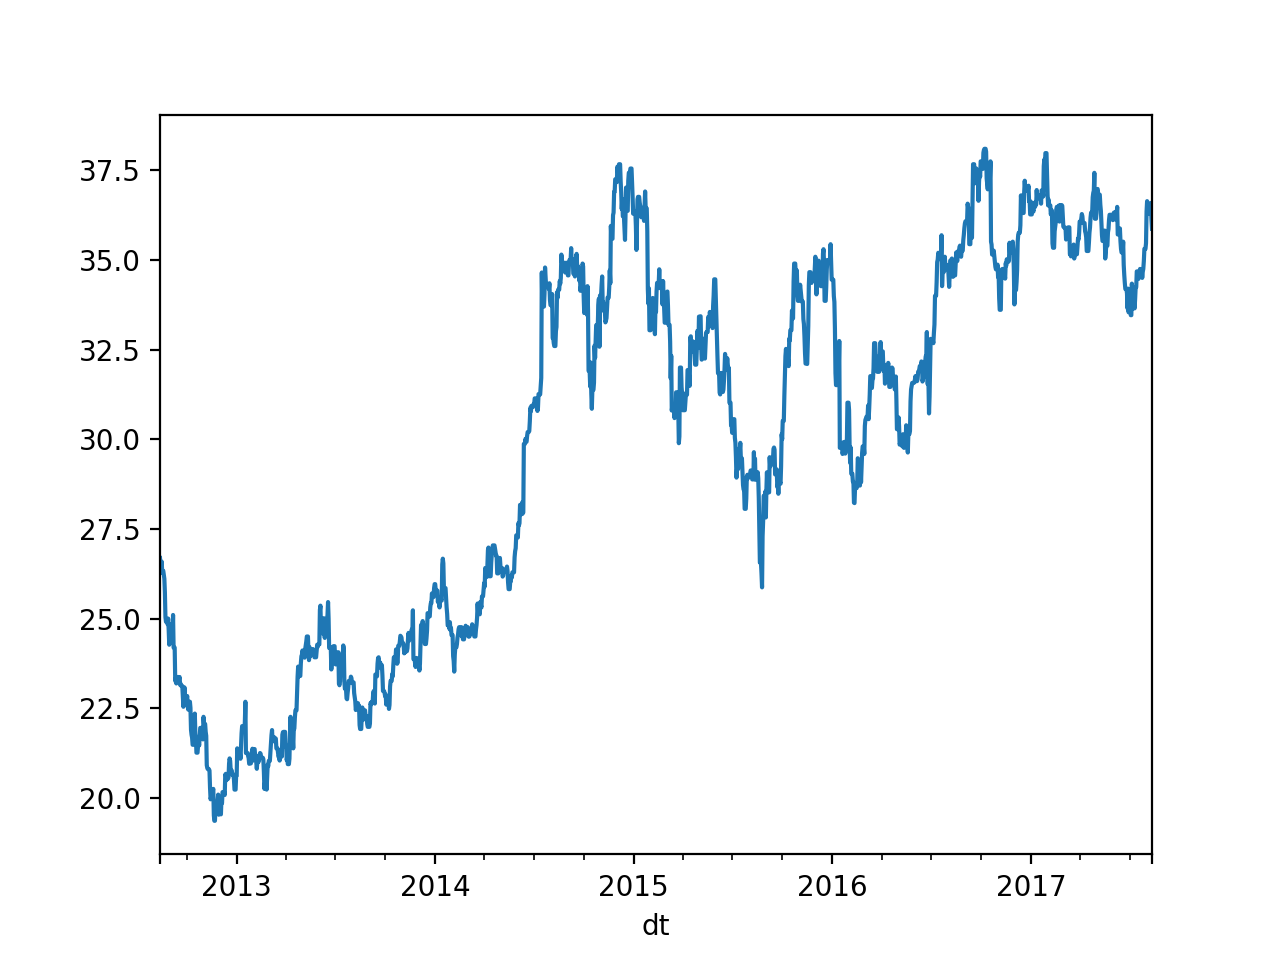

In [5]:
%matplotlib notebook
df["close"].plot()

# Step 2) Run Data Preparation Locally

## Modify Data Preparation Code

In the following cell, you can modify the data preparation code or leave it as is.

In [15]:
%%writefile model/data_prep_long_short_predict.py
#!/usr/bin/env python

import numpy as np
import pandas as pd
import talib as ta
from talib.abstract import *
import math

prefix = '/opt/ml/'
input_path = prefix + 'input/data/training'

data_orig_file = input_path+'/data_orig.csv'
data_file = input_path+'/data.csv'

d = pd.read_csv(data_orig_file,infer_datetime_format=True, parse_dates=['dt'], index_col=['dt'])
print(d.head())

repeatCount=15
repeatStep=1
lookBack=repeatCount*repeatStep
forwardWindow=5

profitTarget=0.005
stopTarget=0.0025

iCount=lookBack

# header
hData=["dt"]
hData.append("close")
for a in range(0,repeatCount):
    hData.append("sma"+str((a+1)*repeatStep))
for a in range(0,repeatCount):
    hData.append("roc"+str((a+1)*repeatStep))
hData.append("long")

# data
tData=[]

inputs = {
    'close': np.array(d["close"])
}
sma=[]
for a in range(0,repeatCount):
    sma.append(SMA(inputs,timeperiod=(a+1)*repeatStep+1))
roc=[]
for a in range(0,repeatCount):
    roc.append(ROC(inputs,timeperiod=(a+1)*repeatStep+1))

closeList=d["close"]
dLen=len(d)
n=0
lCount=0
sCount=0
nCount=0
n=0
for idx,row in d.iterrows():
    if True:
        dt1=idx
        cl=row["close"]
        inputRec=[]
        inputRec.append(idx)

        inputRec0=[]

        #close
        inputRec0.append(cl)

        #sma
        for a in range(0,repeatCount):
            if math.isnan(sma[a][n]):
                inputRec0.append(cl)
            else:
                inputRec0.append(sma[a][n])

        m1=min(inputRec0)
        m2=max(inputRec0)
        for a in inputRec0:
            if m2-m1==0:
                inputRec.append(0)
            else:
                inputRec.append((a-m1)/(m2-m1))

        #roc
        for a in range(0,repeatCount):
            if math.isnan(roc[a][n]):
                inputRec.append(0)
            else:
                inputRec.append(roc[a][n])

        rClose=closeList[min(dLen-1,n+forwardWindow)]

        #long/short
        long=0
        if rClose-cl>0:
            long=1
            lCount=lCount+1
        inputRec.append(long)
        
        tData.append(inputRec)
        n=n+1
          
print("lCount=%s" % (lCount))
df1=pd.DataFrame(tData,columns=hData)
df1.set_index(pd.DatetimeIndex(df1['dt']), inplace=True)
del df1['dt']
 
df1.to_csv(data_file)
print(df1.head())
print("count=%s" % (len(df1)))

Overwriting model/data_prep_long_short_predict.py


## Run Data Preparation Locally in a Docker Container

In [16]:
!cp model/data_prep_$(cat model/model_name).py model/train
!chmod 777 model/train
!docker build -t data_prep_$(cat model/model_name) .
!docker run -v $(pwd)/local_test/test_dir:/opt/ml --rm data_prep_$(cat model/model_name) train

Sending build context to Docker daemon  4.732MB
Step 1/21 : FROM tensorflow/tensorflow:2.1.0rc2-py3
 ---> 021062082fec
Step 2/21 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget          python3          nginx          ca-certificates     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 12a128d4695c
Step 3/21 : RUN wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz && tar -xzf ta-lib-0.4.0-src.tar.gz && cd ta-lib/ && ./configure --prefix=/usr && make && make install && cd ../ && rm -rf ta-lib && rm ta-lib-0.4.0-src.tar.gz
 ---> Using cache
 ---> 5f07f29f1b39
Step 4/21 : RUN wget https://bootstrap.pypa.io/get-pip.py && python get-pip.py
 ---> Using cache
 ---> 81276d67b93e
Step 5/21 : RUN pip install numpy
 ---> Using cache
 ---> 413ac0989772
Step 6/21 : RUN pip install scipy
 ---> Using cache
 ---> 7c9430f8da3d
Step 7/21 : RUN pip install scikit-learn
 ---> Using cache
 ---> cf85f1d766cd
Step 8/21 : RUN pip i

## Create Training and Test Data

In [20]:
df = pd.read_csv("local_test/test_dir/input/data/training/data.csv",infer_datetime_format=True, parse_dates=['dt'], index_col=['dt'])
print("totalCount=%s" % len(df))

trainCount=int(len(df)*0.4)
dfTrain = df.iloc[:trainCount]
dfTrain.to_csv('local_test/test_dir/input/data/training/data_train.csv')
print("trainCount=%s" % len(dfTrain))

dfTest = df.iloc[trainCount:]
dfTest.to_csv('local_test/test_dir/input/data/training/data_test.csv')
print("testCount=%s" % len(dfTest))
dfTest.head()

totalCount=1825
trainCount=730
testCount=1095


,close,sma1,sma2,sma3,sma4,sma5,sma6,sma7,sma8,sma9,...,roc7,roc8,roc9,roc10,roc11,roc12,roc13,roc14,roc15,long
dt,,,,,,,,,,,,,,,,,,,,,
2014-08-13,1.000000,0.584681,0.414843,0.240010,0.135109,0.065176,0.025010,0.012012,0.000000,0.095718,...,3.900061,0.146843,1.066983,1.066983,1.066983,0.619652,-0.727802,-0.263235,-0.379784,1
2014-08-14,0.918946,1.000000,0.699426,0.521277,0.329281,0.201283,0.109857,0.051418,0.023978,0.000000,...,3.349574,3.412553,-0.323054,0.592768,0.592768,0.592768,0.147536,-1.193595,-0.731208,1
2014-08-15,1.000000,0.888742,0.903254,0.675901,0.518206,0.345353,0.221887,0.129288,0.065865,0.030607,...,4.559364,4.049939,4.113346,0.352423,1.274452,1.274452,1.274452,0.826202,-0.524017,1
2014-08-16,1.000000,1.000000,0.919085,0.920844,0.717150,0.562005,0.387863,0.257256,0.155673,0.082850,...,4.815951,4.559364,4.049939,4.113346,0.352423,1.274452,1.274452,1.274452,0.826202,1
2014-08-17,1.000000,1.000000,1.000000,0.934257,0.931398,0.744650,0.593291,0.419745,0.284765,0.176781,...,4.815951,4.815951,4.559364,4.049939,4.113346,0.352423,1.274452,1.274452,1.274452,1


# Step 3) Train the Model

In the following cell, you can modify the model training code or leave it as is.

In [21]:
%%writefile model/model_long_short_predict.py
#!/usr/bin/env python
from __future__ import print_function

import os
import sys
import traceback
import math
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.layers import Dropout, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor

yLen=1
b=0

# Optional
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# These are the paths to where SageMaker mounts interesting things in your
# container.
prefix = '/opt/ml/'

input_path = prefix + 'input/data/training/data_train.csv'
test_path = prefix + 'input/data/training/data_test.csv'

output_path = os.path.join(prefix, 'output')
model_path = os.path.join(prefix, 'model')

# Process and prepare the data
def data_process(df):
    global yLen
    global b
    dataX=[]
    dataY=[]
    for idx,row in df.iterrows():
        row1=[]
        r=row[1:len(row)-yLen]
        for a in r:
            row1.append(a)
        x=np.array(row1)
        y=np.array(row[len(row)-yLen:])
        b=len(x)
        dataX.append(x)
        dataY.append(y)
    dataX=np.array(dataX)
    dataY=np.array(dataY)
    return dataX,dataY,b

def build_classifier():
    global b
    global yLen
    print("build_classifier:b=%s,yLen=%s" % (b,yLen))
    model = Sequential()
    model.add(Dense(b, input_dim=b, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(int(b/2), kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(yLen,kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def generate_model(dataX, dataY, b):
    model=build_classifier()
    model.fit(dataX, dataY, epochs=100, batch_size=1)
    scores = model.evaluate(dataX, dataY, verbose=0)
    print("Training Data %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    return model
        
def train():
    print('Starting the training.')
    try:
        raw_data = pd.read_csv(input_path)
        #print(raw_data)
        X, y, b = data_process(raw_data)
        model = generate_model(X, y, b)
        model.save(os.path.join(model_path, 'model.h5'))
        
        print('Training is complete. Model saved.')
        
        raw_data = pd.read_csv(test_path)
        testX, testY, b = data_process(raw_data)
        scores = model.evaluate(testX, testY, verbose=0)
        print("Test Data %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        
    except Exception as e:
        # Write out an error file. This will be returned as the failure
        # Reason in the DescribeTrainingJob result.
        trc = traceback.format_exc()
        with open(os.path.join(output_path, 'failure'), 'w') as s:
            s.write('Exception during training: ' + str(e) + '\n' + trc)
        # Printing this causes the exception to be in the training job logs
        print(
            'Exception during training: ' + str(e) + '\n' + trc,
            file=sys.stderr)
        # A non-zero exit code causes the training job to be marked as Failed.
        sys.exit(255)

if __name__ == '__main__':
    train()

    # A zero exit code causes the job to be marked a Succeeded.
    sys.exit(0)

Overwriting model/model_long_short_predict.py


### Option 1: Train Locally

You can choose if you want to do the training locally (Option 1) or remote via SageMaker (Option 2).

In [ ]:
# Build Local ML Image
!echo $(cat model/model_name) 
!cp model/model_$(cat model/model_name).py model/train
!chmod 777 model/train
!docker build -t model_$(cat model/model_name) .
!docker run -v $(pwd)/local_test/test_dir:/opt/ml --rm model_$(cat model/model_name) train

long_short_predict
Sending build context to Docker daemon  2.564MB
Step 1/21 : FROM tensorflow/tensorflow:2.1.0rc2-py3
 ---> 021062082fec
Step 2/21 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget          python3          nginx          ca-certificates     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 12a128d4695c
Step 3/21 : RUN wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz && tar -xzf ta-lib-0.4.0-src.tar.gz && cd ta-lib/ && ./configure --prefix=/usr && make && make install && cd ../ && rm -rf ta-lib && rm ta-lib-0.4.0-src.tar.gz
 ---> Using cache
 ---> 5f07f29f1b39
Step 4/21 : RUN wget https://bootstrap.pypa.io/get-pip.py && python get-pip.py
 ---> Using cache
 ---> 81276d67b93e
Step 5/21 : RUN pip install numpy
 ---> Using cache
 ---> 413ac0989772
Step 6/21 : RUN pip install scipy
 ---> Using cache
 ---> 7c9430f8da3d
Step 7/21 : RUN pip install scikit-learn
 ---> Using cache
 ---> cf85f1d766cd
St

730/730 [==============================] - 1s 1ms/step - loss: 0.6609 - accuracy: 0.6205
Epoch 10/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6515 - accuracy: 0.6247
Epoch 11/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6413 - accuracy: 0.6425
Epoch 12/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6403 - accuracy: 0.6233
Epoch 13/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6463 - accuracy: 0.6329
Epoch 14/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6391 - accuracy: 0.6233
Epoch 15/100



730/730 [==============================] - 1s 1ms/step - loss: 0.6375 - accuracy: 0.6384
Epoch 16/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6412 - accuracy: 0.6534
Epoch 17/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6357 - accuracy: 0.6329
Epoch 18/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6331 - accuracy: 0.6603
Epoch 19/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6274 - accuracy: 0.6425
Epoch 20/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6194 - accuracy: 0.6644
Epoch 21/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6210 - accuracy: 0.6575
Epoch 22/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6166 - accuracy: 0.6534
Epoch 23/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6193 - accuracy: 0.6575
Epoch 24/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6134 - a

730/730 [==============================] - 1s 1ms/step - loss: 0.5946 - accuracy: 0.6863
Epoch 26/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6088 - accuracy: 0.6795
Epoch 27/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6063 - accuracy: 0.6726
Epoch 28/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6037 - accuracy: 0.6753
Epoch 29/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6041 - accuracy: 0.6658
Epoch 30/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5879 - accuracy: 0.6890
Epoch 31/100



730/730 [==============================] - 1s 1ms/step - loss: 0.5996 - accuracy: 0.6795
Epoch 32/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5814 - accuracy: 0.6986
Epoch 33/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5859 - accuracy: 0.6753
Epoch 34/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5835 - accuracy: 0.6863
Epoch 35/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5710 - accuracy: 0.6986
Epoch 36/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5714 - accuracy: 0.6918
Epoch 37/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5777 - accuracy: 0.6945
Epoch 38/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5773 - accuracy: 0.7068
Epoch 39/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5652 - accuracy: 0.6918
Epoch 40/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5721 - a

730/730 [==============================] - 1s 1ms/step - loss: 0.5700 - accuracy: 0.6918
Epoch 42/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5644 - accuracy: 0.7041
Epoch 43/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5632 - accuracy: 0.7082
Epoch 44/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5599 - accuracy: 0.6890
Epoch 45/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5482 - accuracy: 0.7068
Epoch 46/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5574 - accuracy: 0.7151
Epoch 47/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5503 - accuracy: 0.7110
Epoch 48/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5484 - accuracy: 0.7137
Epoch 49/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5565 - accuracy: 0.7027
Epoch 50/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5690 - a

730/730 [==============================] - 1s 1ms/step - loss: 0.5399 - accuracy: 0.7137
Epoch 53/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5483 - accuracy: 0.6932
Epoch 54/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5423 - accuracy: 0.7205
Epoch 55/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5351 - accuracy: 0.7123
Epoch 56/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5171 - accuracy: 0.7178
Epoch 57/100

412/730 [===============>..............] - ETA: 0s - loss: 0.5209 - accuracy: 0.7306


730/730 [==============================] - 1s 1ms/step - loss: 0.5216 - accuracy: 0.7356
Epoch 58/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5442 - accuracy: 0.7247
Epoch 59/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5514 - accuracy: 0.7178
Epoch 60/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5341 - accuracy: 0.7041
Epoch 61/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5489 - accuracy: 0.7082
Epoch 62/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5316 - accuracy: 0.7178
Epoch 63/100



730/730 [==============================] - 1s 1ms/step - loss: 0.5445 - accuracy: 0.7096
Epoch 64/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5327 - accuracy: 0.7123
Epoch 65/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5399 - accuracy: 0.7123
Epoch 66/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5331 - accuracy: 0.7205
Epoch 67/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5161 - accuracy: 0.7192
Epoch 68/100

730/730 [==============================] - 1s 2ms/step - loss: 0.5443 - accuracy: 0.7027
Epoch 69/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5305 - accuracy: 0.7288
Epoch 70/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5341 - accuracy: 0.7219
Epoch 71/100

730/730 [==============================] - 1s 1ms/step - loss: 0.4976 - accuracy: 0.7425
Epoch 72/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5035 - a

730/730 [==============================] - 1s 1ms/step - loss: 0.5002 - accuracy: 0.7397
Epoch 74/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5174 - accuracy: 0.7425
Epoch 75/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5162 - accuracy: 0.7479
Epoch 76/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5271 - accuracy: 0.7315
Epoch 77/100

730/730 [==============================] - 1s 1ms/step - loss: 0.4875 - accuracy: 0.7493
Epoch 78/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5262 - accuracy: 0.7274
Epoch 79/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5171 - accuracy: 0.7233
Epoch 80/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5078 - accuracy: 0.7329
Epoch 81/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5095 - accuracy: 0.7438
Epoch 82/100

730/730 [==============================] - 1s 1ms/step - loss: 0.4976 - a

730/730 [==============================] - 1s 1ms/step - loss: 0.5157 - accuracy: 0.7342
Epoch 84/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5051 - accuracy: 0.7342
Epoch 85/100

522/730 [====================>.........] - ETA: 0s - loss: 0.4870 - accuracy: 0.7471

#### Copy Model Artifact to Strategies Folder

In [26]:
!cp local_test/test_dir/model/model.h5 ../1_strategies/model/model_$(cat model/model_name).h5
!ls -la ../1_strategies/model/model_*.h5

-rw-r--r-- 1 ec2-user ec2-user 45936 Jan  9 05:27 ../1_strategies/model/model_long_short_predict.h5


### Option 2: Remote Training via SageMaker

You can choose if you want to do the training locally (Option 1) or remote via SageMaker (Option 2).

In [27]:
# Deploy ML Image to ECS
!./build_and_push.sh

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Sending build context to Docker daemon  2.648MB
Step 1/21 : FROM tensorflow/tensorflow:2.1.0rc2-py3
 ---> 021062082fec
Step 2/21 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget          python3          nginx          ca-certificates     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 12a128d4695c
Step 3/21 : RUN wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz && tar -xzf ta-lib-0.4.0-src.tar.gz && cd ta-lib/ && ./configure --prefix=/usr && make && make install && cd ../ && rm -rf ta-lib && rm ta-lib-0.4.0-src.tar.gz
 ---> Using cache
 ---> 5f07f29f1b39
Step 4/21 : RUN wget https://bootstrap.pyp

In [28]:
import os
import sagemaker as sage
from sagemaker import get_execution_role
import datetime
from sagemaker.tensorflow import TensorFlow

model_name=''
with open('model/model_name', 'r') as file:
    model_name = file.read().replace('\n', '')

role = get_execution_role()
sess = sage.Session()

WORK_DIRECTORY = 'local_test/test_dir/input/data/training'
prefix = 'model_'+model_name
job_name=prefix.replace('_','-')

data_location = sess.upload_data(WORK_DIRECTORY, key_prefix='data')
print(data_location)

account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = f'{account}.dkr.ecr.{region}.amazonaws.com/{prefix}:latest'

classifier = sage.estimator.Estimator(
    image_name=image,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    output_path="s3://{}/output".format(sess.default_bucket()),
    sagemaker_session=sess,
    base_job_name=job_name)
classifier.fit(data_location)

s3://sagemaker-us-east-1-547919252256/data
2020-01-09 05:27:26 Starting - Starting the training job...
2020-01-09 05:27:27 Starting - Launching requested ML instances......
2020-01-09 05:28:31 Starting - Preparing the instances for training......
2020-01-09 05:29:31 Downloading - Downloading input data...
2020-01-09 05:29:59 Training - Downloading the training image........2020-01-09 05:31:31.227174: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2020-01-09 05:31:31.227290: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2020-01-09 05:31:31.227313: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU


2020-01-09 05:31:29 Training - Training image download completed. Training in progress.436/730 [================>.............] - ETA: 0s - loss: 0.6621 - accuracy: 0.5734
730/730 [==============================] - 1s 1ms/step - loss: 0.6635 - accuracy: 0.5753
Epoch 12/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6725 - accuracy: 0.6151
Epoch 13/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6604 - accuracy: 0.6082
Epoch 14/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6657 - accuracy: 0.6041
Epoch 15/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6513 - accuracy: 0.6575
Epoch 16/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6512 - accuracy: 0.6370
Epoch 17/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6604 - accuracy: 0.6342
Epoch 18/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6542 - accuracy: 0.6438
Epoch 19/100

730

730/730 [==============================] - 1s 1ms/step - loss: 0.6417 - accuracy: 0.6452
Epoch 24/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6305 - accuracy: 0.6521
Epoch 25/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6319 - accuracy: 0.6479
Epoch 26/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6370 - accuracy: 0.6479
Epoch 27/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6392 - accuracy: 0.6411
Epoch 28/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6270 - accuracy: 0.6452
Epoch 29/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6164 - accuracy: 0.6603
Epoch 30/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6268 - accuracy: 0.6562
Epoch 31/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6179 - accuracy: 0.6630
Epoch 32/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6256 - a

730/730 [==============================] - 1s 1ms/step - loss: 0.6066 - accuracy: 0.6712
Epoch 36/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5981 - accuracy: 0.6630
Epoch 37/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6200 - accuracy: 0.6315
Epoch 38/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6094 - accuracy: 0.6767
Epoch 39/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5946 - accuracy: 0.6849
Epoch 40/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6068 - accuracy: 0.6671
Epoch 41/100

730/730 [==============================] - 1s 1ms/step - loss: 0.6047 - accuracy: 0.6795
Epoch 42/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5950 - accuracy: 0.6548
Epoch 43/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5976 - accuracy: 0.6726
Epoch 44/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5976 - a

730/730 [==============================] - 1s 1ms/step - loss: 0.6069 - accuracy: 0.6712
Epoch 47/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5871 - accuracy: 0.6685
Epoch 48/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5964 - accuracy: 0.6699
Epoch 49/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5794 - accuracy: 0.6726
Epoch 50/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5842 - accuracy: 0.6795
Epoch 51/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5898 - accuracy: 0.6589
Epoch 52/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5701 - accuracy: 0.6836
Epoch 53/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5781 - accuracy: 0.6863
Epoch 54/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5796 - accuracy: 0.6890
Epoch 55/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5765 - a

730/730 [==============================] - 1s 1ms/step - loss: 0.5827 - accuracy: 0.6890
Epoch 59/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5778 - accuracy: 0.6822
Epoch 60/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5714 - accuracy: 0.6945
Epoch 61/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5719 - accuracy: 0.6863
Epoch 62/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5755 - accuracy: 0.6932
Epoch 63/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5606 - accuracy: 0.6932
Epoch 64/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5589 - accuracy: 0.6904
Epoch 65/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5769 - accuracy: 0.6795
Epoch 66/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5765 - accuracy: 0.6877
Epoch 67/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5492 - a

730/730 [==============================] - 1s 1ms/step - loss: 0.5335 - accuracy: 0.7192
Epoch 71/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5596 - accuracy: 0.7014
Epoch 72/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5386 - accuracy: 0.7055
Epoch 73/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5482 - accuracy: 0.7219
Epoch 74/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5633 - accuracy: 0.7014
Epoch 75/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5403 - accuracy: 0.7192
Epoch 76/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5314 - accuracy: 0.7192
Epoch 77/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5309 - accuracy: 0.7151
Epoch 78/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5497 - accuracy: 0.6836
Epoch 79/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5586 - a

730/730 [==============================] - 1s 1ms/step - loss: 0.5261 - accuracy: 0.7288
Epoch 83/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5228 - accuracy: 0.7137
Epoch 84/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5143 - accuracy: 0.7192
Epoch 85/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5249 - accuracy: 0.7356
Epoch 86/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5620 - accuracy: 0.7123
Epoch 87/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5276 - accuracy: 0.7288
Epoch 88/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5286 - accuracy: 0.7068
Epoch 89/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5148 - accuracy: 0.7178
Epoch 90/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5160 - accuracy: 0.7151
Epoch 91/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5182 - a

730/730 [==============================] - 1s 1ms/step - loss: 0.5235 - accuracy: 0.7192
Epoch 95/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5042 - accuracy: 0.7397
Epoch 96/100

730/730 [==============================] - 1s 1ms/step - loss: 0.4969 - accuracy: 0.7425
Epoch 97/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5054 - accuracy: 0.7397
Epoch 98/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5222 - accuracy: 0.7123
Epoch 99/100

730/730 [==============================] - 1s 1ms/step - loss: 0.4738 - accuracy: 0.7644
Epoch 100/100

730/730 [==============================] - 1s 1ms/step - loss: 0.5054 - accuracy: 0.7329
Training Data accuracy: 77.53%
Training is complete. Model saved.
Test Data accuracy: 49.77%



2020-01-09 05:33:10 Uploading - Uploading generated training model
2020-01-09 05:33:10 Completed - Training job completed
Training seconds: 219
Billable seconds: 219


#### Download Model Artifact from Amazon S3 and copy it to Strategies Folder

In [32]:
#Get Model from S3
model_name=classifier.model_data.replace('s3://'+sess.default_bucket()+'/','')
import boto3
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(sess.default_bucket())
my_bucket.download_file(model_name,'model.tar.gz')
!tar -xzf model.tar.gz
!rm model.tar.gz
!cp model.h5 ../1_strategies/model/model_$(cat model_name).h5
!ls -la ../1_strategies/model/model_*.h5

cat: model_name: No such file or directory
-rw-r--r-- 1 ec2-user ec2-user 45936 Jan  9 05:34 ../1_strategies/model/model_.h5
-rw-r--r-- 1 ec2-user ec2-user 45936 Jan  9 05:27 ../1_strategies/model/model_long_short_predict.h5
